<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/-Taxi-Trip-Time-Prediction-/blob/main/Taxi_Trip_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

---
# importing
---

In [1]:
#importing all the important librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# converting the csv file to data frame
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/capstone ml reg 2/NYC Taxi Data.csv')

---
# Functions
----

In [4]:
# defining blank list for the input of scores of models
mean_sq_error=[]
root_mean_sq_error=[]
mean_abs_per_error=[]
r2_list=[]
adj_r2_list=[]
training_time_min=[]

In [5]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
# making a function to train the model and evaluate the model
def train_and_score (model,X_test,X_train,Y_test,Y_train, graph=True, best_parameter=True, best_score=True):
  '''
  train the model and gives mse,rmse,r2,adj r2 score of the model
  can be used for any model where y is not transformed 
  '''

  #training the model    
  model.fit(X_train,Y_train)

  # finding the best parameters of the model if any 
  if best_parameter==True:
    try:
      # finding the best parameters of the model if any 
      print("The best parameters found out to be :" ,model.best_params_)
    except:
      pass

  if best_score==True:
    try:
      print(" \nwhere negative mean squared error is: ", model.best_score_,'\n')
    except:
      pass


  #predicting the values of y from x via model
  Y_pred = model.predict(X_test)

  #finding mean_squared_error
  MSE  = mean_squared_error(Y_test,Y_pred)
  print("MSE :" , MSE)

  #finding root mean squared error
  RMSE = np.sqrt(MSE)
  print("RMSE :" ,RMSE)

  #finding mean_absolute_percentage_error
  MAPE = mean_absolute_percentage_error(Y_test,Y_pred)
  print("MAPE :" ,MAPE)
  
  #finding the r2 score
  r2 = r2_score(Y_test,Y_pred)
  print("R2 :" ,r2)
  
  #finding the adjusted r2 score
  adj_r2=1-(1-r2_score(Y_test,Y_pred))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
  print("Adjusted R2 : ",adj_r2,'\n')

  mean_sq_error.append(MSE)
  root_mean_sq_error.append(RMSE)
  r2_list.append(r2)
  adj_r2_list.append(adj_r2)
  mean_abs_per_error.append(MAPE)

  # ploting the line graph of first 100 actual and predicted values 
  if graph ==True:
    plt.figure(figsize=(20,10))
    plt.plot((Y_pred)[:100])
    plt.plot((np.array(Y_test)[:100]))
    plt.legend(["Predicted","Actual"])
    plt.show()

In [6]:
#creating function to get features importance of all the tree based model
def get_features_importance(optimal_model):
  imp_feat=pd.DataFrame(index=X.columns,data=optimal_model.feature_importances_,columns=['importance'])
  imp_feat=imp_feat[imp_feat['importance']>0]
  imp_feat=imp_feat.sort_values('importance')
  plt.figure(figsize=(15,5))
  print(f'==========================Features Importance============================\n\n {optimal_model}\
  \n=========================================================================\n') 
  sns.barplot(data=imp_feat,x=imp_feat.index,y='importance')
  plt.xticks(rotation=90);
   

 instaling lime in colab 

In [7]:
pip install lime

     |████████████████████████████████| 275 kB 4.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=28dcc1de6d7a52941d70d5e8e393d0290637ec34beb92409919949a4d3f48495
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [8]:
#  importing lime 
import lime
import lime.lime_tabular

In [9]:
# LIME SECTION

def LimeTabularExplainer_table(model,instance,num_features,dependent_var):
  # creating a data frame to store all the independent features
  X=final_df.drop(dependent_var,axis=1)
  # fetching all the features name from independent variable
  feature_names =list(X.columns)

  # setting up the lime tablular 
  explainer = lime.lime_tabular.LimeTabularExplainer(X.values,feature_names=feature_names,mode='regression')

  # selecting the instace to explain
  choosen_instance = X.reset_index(drop=True).loc[[instance]].values[0]
  exp = explainer.explain_instance(choosen_instance, model.predict, num_features=num_features)
  # showing the lime graph on the screen 
  exp.show_in_notebook(show_table=True)


In [10]:
# creating a function to check Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
  '''
  returns the vif of the given data 
  '''

  # creating a data frame
  vif = pd.DataFrame()
  # storing the columns names for the data  
  vif["variables"] = X.columns
  # Calculating VIF
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  #  returing the vif dataframe
  return(vif)

In [11]:
# coustom function to return the period of the day
def time_range(x):
  '''
  returns the period of the day with input of interger 00-24
  '''
  if x in range(6,12):
    return 'Morning'
  elif x in range(12,17):
    return 'Afternoon'
  elif x in range(17,24):
    return 'Evening'
  else:
    return 'Night'

---
# Dataset inspection
---

In [12]:
# seeing top 5 row of data
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
# fetching the no of rows and collumns fo the data
df.shape

(1458644, 11)

In [14]:
# droping the id as it is has unique values for each row
df=df.drop('id',axis=1)

In [15]:
# getting the datatypes and null value count of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   pickup_datetime     1458644 non-null  object 
 2   dropoff_datetime    1458644 non-null  object 
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  object 
 9   trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 111.3+ MB


In [16]:
#checking for missing values
df.isna().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

observation 
* Does not have any null values

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


---
# Feature engineering
---

In [18]:
#converting the data type to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [19]:
# storing the the week day of pick up date time
df['pickup_day'] = df['pickup_datetime'].dt.weekday
# storing the the month from pick up date time
df['pickup_month'] = df['pickup_datetime'].dt.month
# storing the the hour from pick up date time
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [20]:
# finding pickup period by coustom function
df['pickup_period']=df['pickup_hour'].apply(lambda x: time_range(x))

In [21]:
# drop the pickup hour as it is no longer needed
df=df.drop('pickup_hour',axis=1)

In [22]:
# importing vicentry calculator from geopy.distance library
from geopy.distance import vincenty

In [23]:
# finding the distance traveled in km by vincenty using pickup and drop latitule and longtitude
df['distance'] = df.apply(lambda x: vincenty((x['pickup_latitude'], x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis = 1)


In [24]:
# finding the speed of travel using ditance and trip duration
df['avg_speed']=df.distance*3600/df.trip_duration

In [25]:
# checking for all the new data type of the data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  int64         
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   dropoff_datetime    1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
 10  pickup_day          1458644 non-null  int64         
 11  pickup_month        1458644 non-null  int64         
 12  pickup_period       1458644 non-null  object        
 13  distance    

---
# univariant analysis
---

## column no 1 vendor_id


In [26]:
df_og=df.copy()

Text(0, 0.5, 'Number of trip')

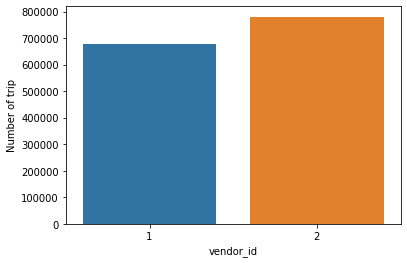

In [27]:
# countplot for different classes in a column
sns.countplot(df.vendor_id)
# setting lables for y axis
plt.ylabel('Number of trip')

observation
* Their are only two vendors
* Vendor no 2 has higher no of count than 1

## column no 4 passanger count

Text(0, 0.5, 'Number of trip')

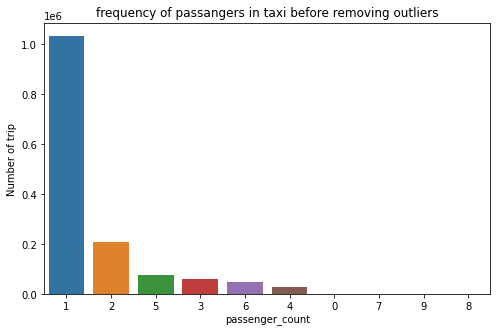

In [28]:
# setting the figure size 
plt.figure(figsize=(8,5))
# countplot for different classes in a column
sns.countplot(x = 'passenger_count',
              data = df,
              order = df['passenger_count'].value_counts().index)
# setting title
plt.title('frequency of passangers in taxi before removing outliers')
# setting lables for y axis
plt.ylabel('Number of trip')


In [29]:
# frequency of number of passangers
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [30]:
#Removeing entries 0,7,8,9 from  passenger count feature
df_og = df_og[df_og.passenger_count!=0]
df_og = df_og[df_og.passenger_count < 7]

Text(0, 0.5, 'Number of trip')

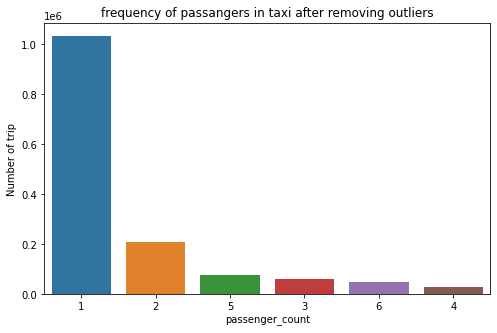

In [31]:
# setting the figure size 
plt.figure(figsize=(8,5))
# countplot for different classes in a column
sns.countplot(x = 'passenger_count',
              data = df_og,
              order = df_og['passenger_count'].value_counts().index)
# setting title
plt.title('frequency of passangers in taxi after removing outliers')
# setting lables for y axis
plt.ylabel('Number of trip')

In [32]:
# fequency of number of passangers
df_og.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

observation 
* There are 60 entries which have 0 passengers which can be outlier or the driver made a mistake while entering
* passenger count with 7,8,9 might be outliers so we will remove them 

## column no 9 store_and_fwd_flag

Text(0, 0.5, 'Number of trip')

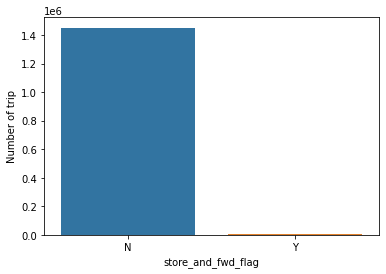

In [33]:
# countplot for different classes in a column
sns.countplot(df.store_and_fwd_flag)
# setting lables for y axis
plt.ylabel('Number of trip')

In [34]:
# fequency of different classes in a column
df.store_and_fwd_flag.value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [35]:
# finding the percentage of y flag
8045/(1450599+8045)*100

0.5515396491535974

observation 
* very few(0.55 percent) of the records was held in vehicle memory before sending to the vendor

## column no 10 trip_duration

Text(0, 0.5, 'Number of trip')

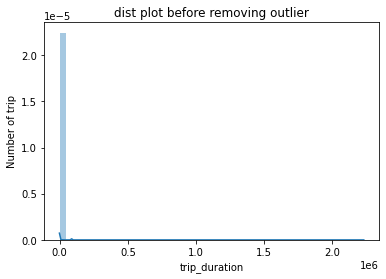

In [36]:
# ploting distibution for 100000 random samples from data
sns.distplot(df.trip_duration.sample(100000))
# setting title
plt.title('dist plot before removing outlier')
# setting lables for y axis
plt.ylabel('Number of trip')

Text(0.5, 1.0, 'box plot before removing outlier')

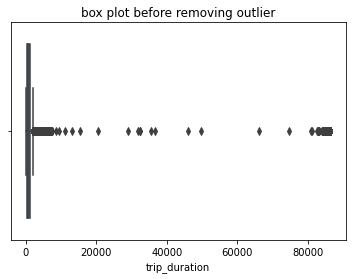

In [37]:
# ploting histogram for 100000 random samples from data
sns.boxplot(df.trip_duration.sample(100000))
# setting title
plt.title('box plot before removing outlier')

In [38]:
# removing one percent of the extreem values as outliers
upper_lim=df_og['trip_duration'].quantile(.99)
df_og=df_og[df_og['trip_duration']<=upper_lim]

Text(0.5, 1.0, 'box plot after removing outlier')

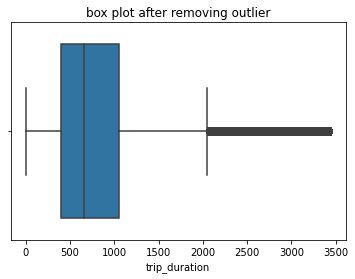

In [39]:
# Drawing a single horizontal boxplot
sns.boxplot(df_og.trip_duration)
# setting title
plt.title('box plot after removing outlier')

Text(0, 0.5, 'Number of trip')

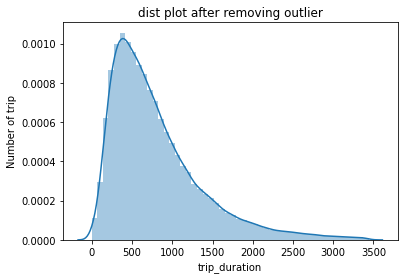

In [40]:
# ploting distibution for 100000 random samples from data
sns.distplot(df_og.trip_duration.sample(100000))
# setting title
plt.title('dist plot after removing outlier')
# setting lables for y axis
plt.ylabel('Number of trip')

Text(0, 0.5, 'Number of trip')

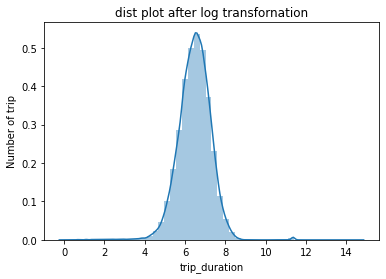

In [41]:
# ploting distibution for 100000 random samples from data
sns.distplot(np.log(df.trip_duration.sample(100000)))
# setting title
plt.title('dist plot after log transfornation')
# setting lables for y axis
plt.ylabel('Number of trip')

observation 
* the data is heavily screwed towards right 
* almost 5 percent of data contains outliers

## column no 11 pickup_day

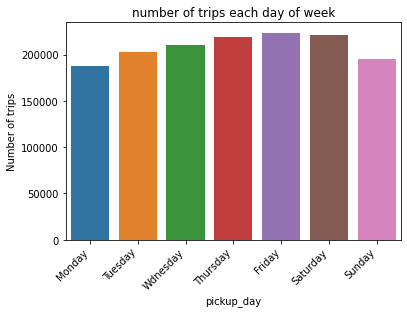

In [42]:
# countplot for different classes in a column
sns.countplot(df.pickup_day)
# setting lables for x axis
locs, labels=plt.xticks()
# storing list of in form of array in variable
day_name=np.array(['Monday','Tuesday','Wdnesday','Thursday','Friday','Saturday','Sunday'])
# rotating the x lables
plt.xticks(locs, day_name,rotation=45, horizontalalignment='right')
# assigning y lables
plt.ylabel('Number of trips')
# setting title
plt.title('number of trips each day of week')
# desplaying the plot
plt.show()

observation
* equal no of booking throughout the week

## Column No 12 pickup_month

Text(0.5, 1.0, 'number of trips each month')

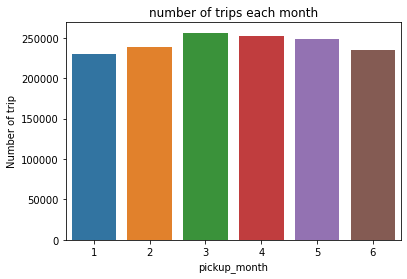

In [43]:
# countplot for different classes in a column
sns.countplot(df.pickup_month)
# setting lables for y axis
plt.ylabel('Number of trip')
# setting title
plt.title('number of trips each month')

## Column No 13 pickup_period 

Text(0, 0.5, 'Number of trip')

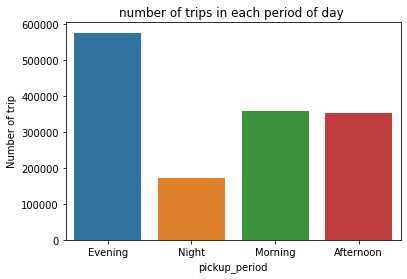

In [44]:
# countplot for different classes in a column
sns.countplot(df.pickup_period)
# setting title
plt.title('number of trips in each period of day ')
# setting lables for y axis
plt.ylabel('Number of trip')


## Column No 14 distance

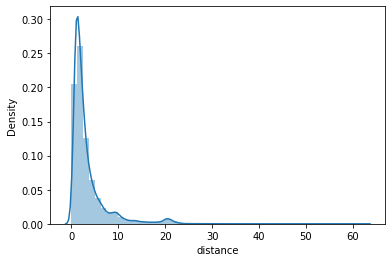

In [45]:
# ploting distibution for 100000 random samples from data
sns.distplot(df.distance.sample(100000))

Text(0, 0.5, 'Number of trip')

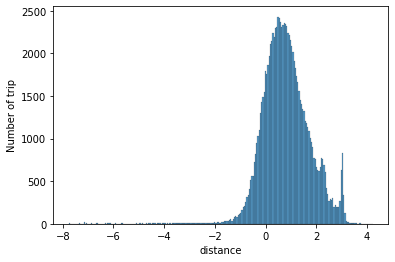

In [46]:
# ploting distibution for 100000 random samples from data
sns.histplot(np.log(df.distance.sample(100000)))
# setting lables for y axis
plt.ylabel('Number of trip')

## Column No 15 avg_speed

Text(0.5, 1.0, 'distance plot before removing outliers')

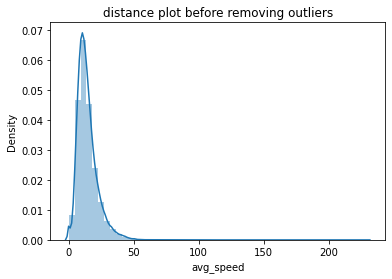

In [47]:
# ploting distibution for 100000 random samples from data
sns.distplot(df.avg_speed.sample(100000))
# setting title
plt.title('distance plot before removing outliers')

Text(0.5, 1.0, 'box plot before removing outlier')

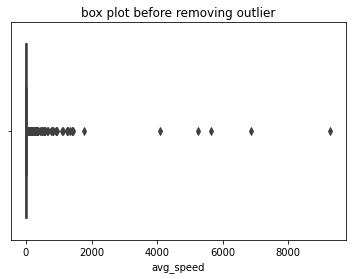

In [48]:
# Drawing a single horizontal boxplot
sns.boxplot(df.avg_speed)
# setting title
plt.title('box plot before removing outlier')

In [49]:
# removing all the rows which have speed above 150 kmph
df_og=df_og[df_og["avg_speed"]<=120]

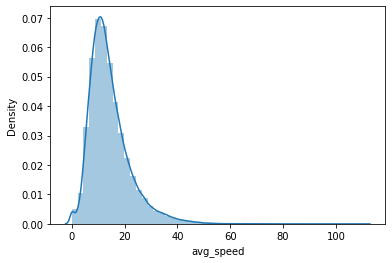

In [50]:
sns.distplot(df_og.avg_speed.sample(100000))

Text(0.5, 1.0, 'box plot after removing outlier')

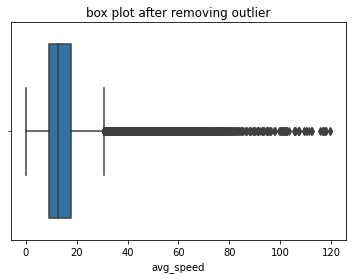

In [51]:
# Drawing a single horizontal boxplot
sns.boxplot(df_og.avg_speed)
# setting title
plt.title('box plot after removing outlier')

observation 
* some have speed which is not possible for taxi (except the taxi is a rocket )

---
# Bivariant analysis
---
ploting graphs of dependent variable againts independent variable 

**Duaration vs Vendor_id**


---






Text(0.5, 1.0, 'trip duration vs vendors')

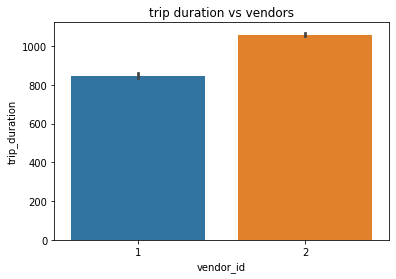

In [52]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df.vendor_id,df.trip_duration)
# setting title
plt.title('trip duration vs vendors')

observation
* vendor 2 have higher trip duration than 1

**Duaration vs passenger count**


---






Text(0.5, 1.0, 'trip duration vs no pf paddanger before removing outliers')

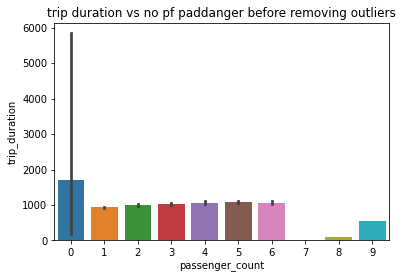

In [53]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df.passenger_count,df.trip_duration)
# setting title
plt.title('trip duration vs no pf paddanger before removing outliers')

Text(0.5, 1.0, 'trip duration vs no pf paddanger after removing outliers')

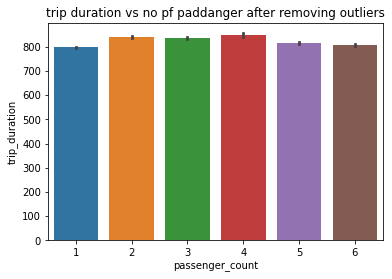

In [54]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df_og.passenger_count,df_og.trip_duration)
# setting title
plt.title('trip duration vs no pf paddanger after removing outliers')

observation
* passenger count 0 has very hight variance in its trip duration as it is an outlier
*  trip duration gradualy increases as the no of passengers increases 

**Duaration vs pickup_day**


---






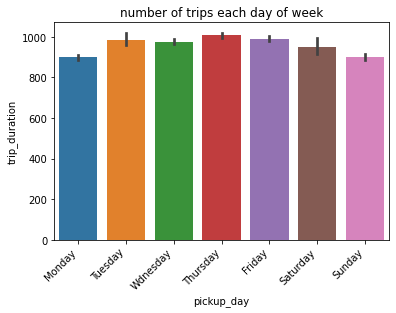

In [55]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df.pickup_day,df.trip_duration)
# setting lables for x axis
locs, labels=plt.xticks()
# storing list of in form of array in variable
day_name=np.array(['Monday','Tuesday','Wdnesday','Thursday','Friday','Saturday','Sunday'])
# rotating the x lables
plt.xticks(locs, day_name,rotation=45, horizontalalignment='right')
# setting title
plt.title('number of trips each day of week')
# desplaying the plot
plt.show()

observation
* Duration of the trip is highest on thursday

**Duaration vs pickup_month**


---






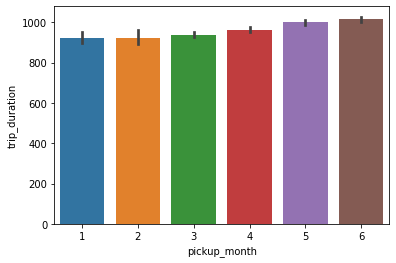

In [56]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df.pickup_month,df.trip_duration)

observation 
* trip duration in 6 month i.e june is the highest 

**Duaration vs pickup_period**


---






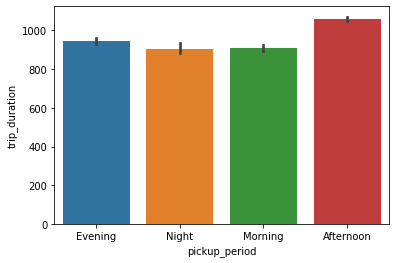

In [57]:
# Draw a set of vertical bar plots grouped by a categorical variable
sns.barplot(df.pickup_period,df.trip_duration)

observation
* people travel alarger distance when the boook a cap in afternoon

**Duaration vs Distance**


---






Text(0.5, 1.0, 'scatter plot of trip duration vs ddistance covered before removing outliers')

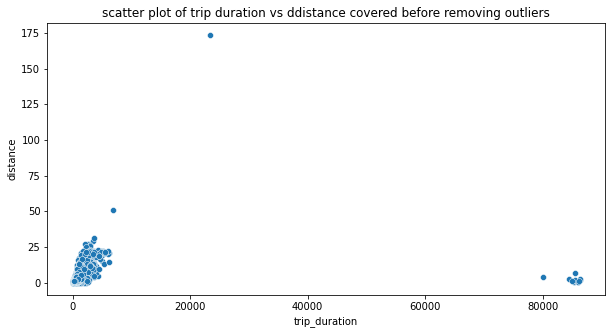

In [58]:
# setting the figure size 
plt.figure(figsize=(10,5))
# scatter plot for duration vs distance for 100000 random samples
sns.scatterplot(df.trip_duration.sample(100000),df.distance.sample(100000))
# setting title
plt.title('scatter plot of trip duration vs ddistance covered before removing outliers')

Text(0.5, 1.0, 'scatter plot of trip duration vs ddistance covered after removing outliers')

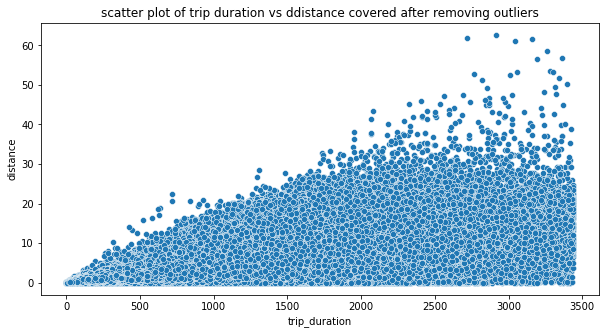

In [59]:
# setting the figure size 
plt.figure(figsize=(10,5))
# scatter plot for duration vs distance 
sns.scatterplot(df_og.trip_duration,df_og.distance)
# setting title
plt.title('scatter plot of trip duration vs ddistance covered after removing outliers')

observation
* distance need some serious outler treetment to find any trend in the graphs

---
# Data cleaing and wrangling
---

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1458644 non-null  int64         
 1   pickup_datetime     1458644 non-null  datetime64[ns]
 2   dropoff_datetime    1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
 10  pickup_day          1458644 non-null  int64         
 11  pickup_month        1458644 non-null  int64         
 12  pickup_period       1458644 non-null  object        
 13  distance    

In [61]:
# removing pickup and dropoff time and location
df=df.drop(['pickup_datetime','dropoff_datetime'],axis=1)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1458644 non-null  int64  
 1   passenger_count     1458644 non-null  int64  
 2   pickup_longitude    1458644 non-null  float64
 3   pickup_latitude     1458644 non-null  float64
 4   dropoff_longitude   1458644 non-null  float64
 5   dropoff_latitude    1458644 non-null  float64
 6   store_and_fwd_flag  1458644 non-null  object 
 7   trip_duration       1458644 non-null  int64  
 8   pickup_day          1458644 non-null  int64  
 9   pickup_month        1458644 non-null  int64  
 10  pickup_period       1458644 non-null  object 
 11  distance            1458644 non-null  float64
 12  avg_speed           1458644 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 144.7+ MB


In [63]:
#Removeing entries 0,7,8,9 from  passenger count value 
df = df[df.passenger_count!=0]
df = df[df.passenger_count < 7]

In [64]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

In [65]:
# removing speed which is above 120 km/hr and distace = 0
df = df[(df['distance']>=0.2) & (df["avg_speed"]<=120)]

In [66]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1441648.0,1.535122,0.498765,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1441648.0,1.665459,1.314694,1.000000,1.000000,1.000000,2.000000,6.000000e+00
pickup_longitude,1441648.0,-73.973597,0.037804,-75.455917,-73.991875,-73.981773,-73.967476,-7.323800e+01
pickup_latitude,1441648.0,40.750997,0.027891,39.803932,40.737423,40.754147,40.768372,4.169680e+01
dropoff_longitude,1441648.0,-73.973503,0.035714,-76.135719,-73.991325,-73.979774,-73.963127,-7.271140e+01
dropoff_latitude,1441648.0,40.751894,0.032233,40.243626,40.735958,40.754570,40.769845,4.169335e+01
trip_duration,1441648.0,964.707812,5256.352279,7.000000,402.000000,667.000000,1079.000000,3.526282e+06
pickup_day,1441648.0,3.049681,1.953953,0.000000,1.000000,3.000000,5.000000,6.000000e+00
pickup_month,1441648.0,3.516585,1.680853,1.000000,2.000000,4.000000,5.000000,6.000000e+00
distance,1441648.0,3.477488,3.963066,0.200014,1.257593,2.119517,3.911226,1.918180e+02


In [67]:
# checking for the shape of the data
df.shape

(1441648, 13)

In [68]:
# seprationg the numeric features and checking for outliers
numeric_features=['trip_duration','distance','avg_speed']

In [69]:
# removing 1 percent of the upper data as outliers
upper_lim_duration=df['trip_duration'].quantile(.99)
print(upper_lim_duration)
df=df[df['trip_duration']<=upper_lim_duration]

3443.0


In [70]:
# removing 1 percent of the upper data as outliers
upper_lim_speed=df['avg_speed'].quantile(.99)
print(upper_lim_speed)
df=df[df['avg_speed']<=upper_lim_speed]

40.74794898902828


In [71]:
# removing 2 percent of the upper data as outliers
upper_lim_distance=df['distance'].quantile(.98)
print(upper_lim_distance)
df=df[df['distance']<=upper_lim_distance]

15.351701291095647


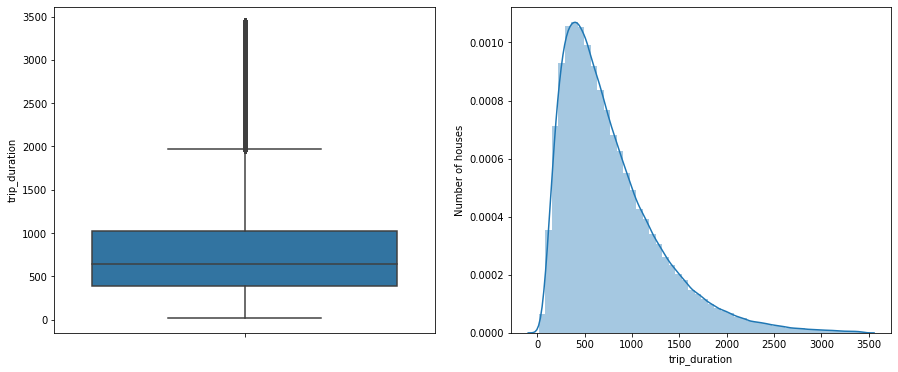

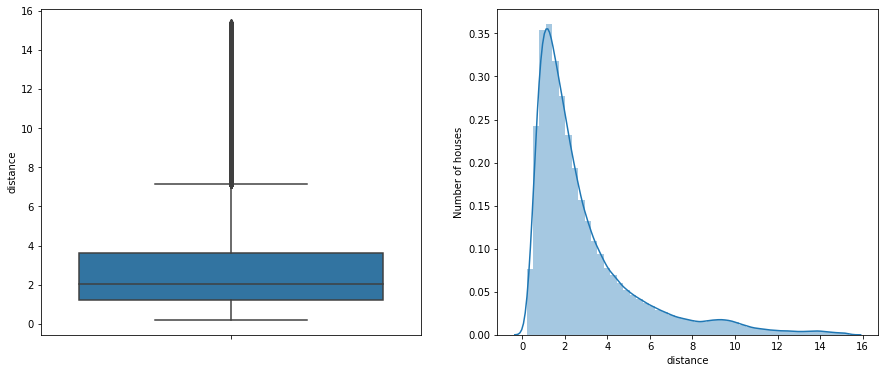

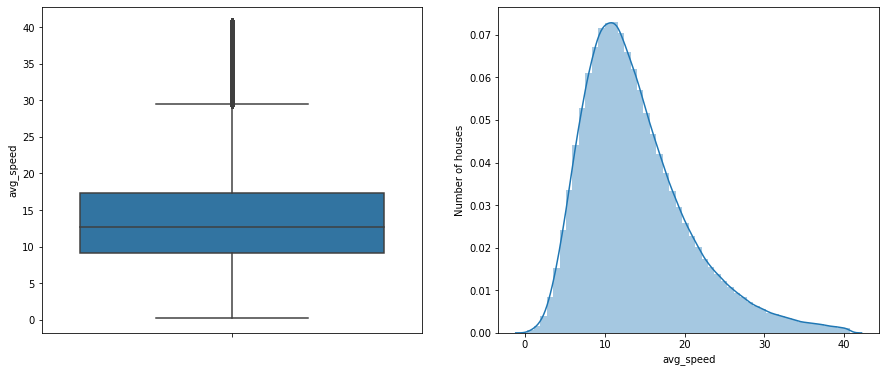

In [72]:
# plotting box and distribution plot of numeric data
for var in numeric_features:
  # setting the figure size 
  plt.figure(figsize=(15,6))
  # setting no of rows collums and index for the plot
  plt.subplot(1, 2, 1)
  # box plot for given numeric feature
  fig = sns.boxplot(y=df[var])
  # setting title
  fig.set_title('')
  # setting lables for y axis
  fig.set_ylabel(var)
  # setting no of rows collums and index for the plot
  plt.subplot(1, 2, 2)
  # ploting distibution for 500000 random samples from data
  fig = sns.distplot(df[var].dropna().sample(500000))
  # setting lables for y axis
  fig.set_ylabel('Number of houses')
  # setting lables for x axis
  fig.set_xlabel(var)
  # desplaying the plot
  plt.show()

---
#data prep
---

In [73]:
# describing the given data 
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,distance,avg_speed
count,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06,1.384699e+06
mean,1.533589e+00,1.662837e+00,-7.397714e+01,4.075282e+01,-7.397532e+01,4.075281e+01,7.763361e+02,3.049486e+00,3.513091e+00,2.912456e+00,1.388183e+01
std,4.988707e-01,1.313545e+00,2.806235e-02,2.429448e-02,2.794590e-02,2.903302e-02,5.224600e+02,1.950932e+00,1.680004e+00,2.547677e+00,6.644577e+00
min,1.000000e+00,1.000000e+00,-7.433240e+01,4.039825e+01,-7.432593e+01,4.041617e+01,1.800000e+01,0.000000e+00,1.000000e+00,2.000146e-01,2.526662e-01
25%,1.000000e+00,1.000000e+00,-7.399210e+01,4.073852e+01,-7.399141e+01,4.073710e+01,3.940000e+02,1.000000e+00,2.000000e+00,1.232060e+00,9.131771e+00
50%,2.000000e+00,1.000000e+00,-7.398205e+01,4.075473e+01,-7.398006e+01,4.075491e+01,6.460000e+02,3.000000e+00,4.000000e+00,2.042105e+00,1.262853e+01
75%,2.000000e+00,2.000000e+00,-7.396854e+01,4.076861e+01,-7.396413e+01,4.076994e+01,1.023000e+03,5.000000e+00,5.000000e+00,3.601008e+00,1.728879e+01
max,2.000000e+00,6.000000e+00,-7.342497e+01,4.169680e+01,-7.342153e+01,4.169335e+01,3.443000e+03,6.000000e+00,6.000000e+00,1.535154e+01,4.074787e+01


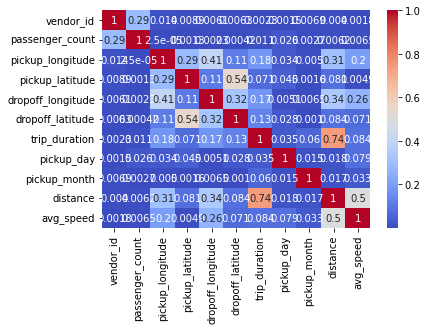

In [74]:
# heat map of the data to check the correlation matrix
sns.heatmap(abs(df.corr()), annot=True, cmap='coolwarm')

In [75]:
# calcuationg vif of independent variables
calc_vif(df[[i for i in df.describe().columns if i not in ['trip_duration','vendor_id'] ]])


,variables,VIF
0,passenger_count,2.604869e+00
1,pickup_longitude,7.182106e+06
2,pickup_latitude,3.961912e+06
3,dropoff_longitude,7.609230e+06
4,dropoff_latitude,3.018401e+06
5,pickup_day,3.482299e+00
6,pickup_month,5.387465e+00
7,distance,3.080493e+00
8,avg_speed,7.338984e+00


In [76]:
# One hot encoding
final_df = pd.get_dummies(df, columns=["vendor_id",
                                         "passenger_count",
                                         "pickup_day",
                                         "pickup_month",
                                         "pickup_period"])

In [77]:
# seeing top 5 row of data
final_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,pickup_day_0,pickup_day_1,pickup_day_2,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,pickup_period_Afternoon,pickup_period_Evening,pickup_period_Morning,pickup_period_Night
0,-73.982155,40.767937,-73.964630,40.765602,N,455,1.502172,11.885316,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.808660,9.820778,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.379687,10.813029,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,-74.010040,40.719971,-74.012268,40.706718,N,429,1.483632,12.450063,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,-73.973053,40.793209,-73.972923,40.782520,N,435,1.187038,9.823760,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


In [78]:
random_df=final_df.sample(n=100000)

In [79]:
# spliting independent variables from data and storing in x variable
X=random_df.drop(['trip_duration','avg_speed','store_and_fwd_flag'],axis=1)
X.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'distance', 'vendor_id_1', 'vendor_id_2',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'pickup_day_0', 'pickup_day_1', 'pickup_day_2', 'pickup_day_3',
       'pickup_day_4', 'pickup_day_5', 'pickup_day_6', 'pickup_month_1',
       'pickup_month_2', 'pickup_month_3', 'pickup_month_4', 'pickup_month_5',
       'pickup_month_6', 'pickup_period_Afternoon', 'pickup_period_Evening',
       'pickup_period_Morning', 'pickup_period_Night'],
      dtype='object')

In [80]:
# spliting dependent variables from data and storing in x variable
y=random_df['trip_duration']
y.head()

1390309     785
437034     1226
1013904     611
857013     1116
1146381     779
Name: trip_duration, dtype: int64

In [81]:
# spliting the data in training and testing 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.25, random_state = 0) 

In [82]:
X_train.head(1)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,pickup_day_0,pickup_day_1,pickup_day_2,pickup_day_3,pickup_day_4,pickup_day_5,pickup_day_6,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,pickup_period_Afternoon,pickup_period_Evening,pickup_period_Morning,pickup_period_Night
211466,-74.005959,40.724289,-74.008476,40.712921,1.280175,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [83]:
X_train.head(1).to_numpy()

array([[-74.00595856,  40.72428894, -74.00847626,  40.71292114,
          1.28017452,   0.        ,   1.        ,   1.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.        ,   0.        ,   0.        ,
          1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ,
          0.        ,   0.        ]])

In [84]:
# scaling the data 
scaler = MinMaxScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

---
# Linear regrestion
---



In [85]:
linear_regression = LinearRegression()

MSE : 110578.47020496918
RMSE : 332.53341216330307
MAPE : 0.4288792855948414
R2 : 0.5918367568929763
Adjusted R2 :  0.5913463529002969 



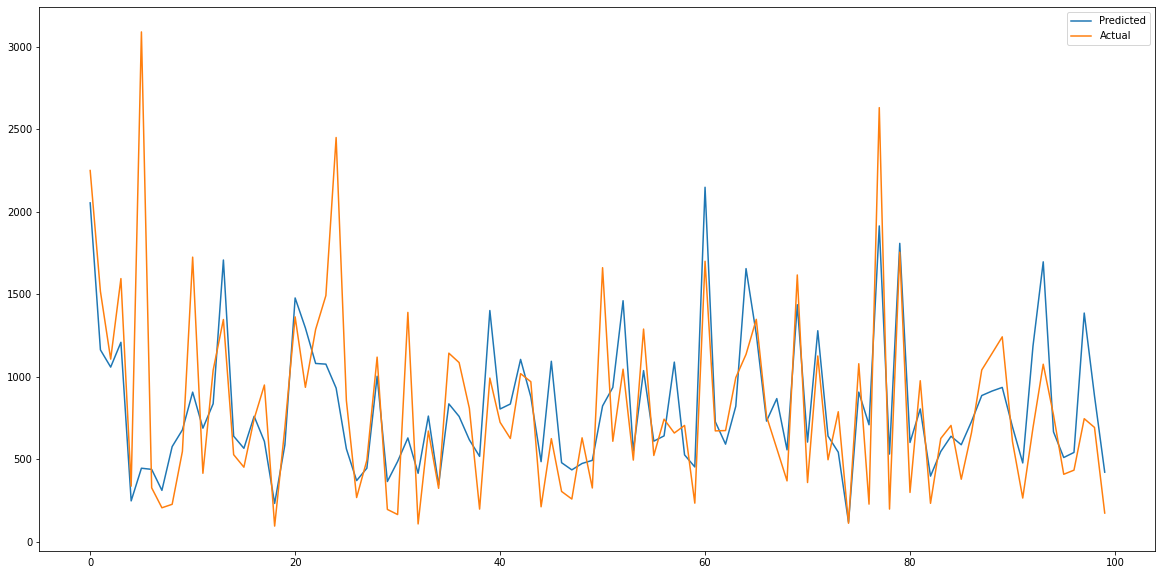

In [86]:
# training and evaluating the model
train_and_score(linear_regression,X_test_lr, X_train_lr, y_test, y_train)

##Regularization

### Lasso 

In [87]:
# importing the Lasso regularization model
from sklearn.linear_model import Lasso

In [88]:
# creating lasso regularization model
lasso = Lasso(alpha=0.001)
#setting the parameters of the 
parameters = {'alpha': [1e-3,1e-2,1e-1,1,10,100]}
lasso_grid = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=3,n_jobs=-1,verbose=5)


In [89]:
# training and evaluating the model
train_and_score(lasso_grid,X_test_lr, X_train_lr, y_test, y_train,graph=False)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The best parameters found out to be : {'alpha': 0.01}
 
where negative mean squared error is:  -108397.14458592136 

MSE : 110578.1866909284
RMSE : 332.5329858689637
MAPE : 0.42894806179736006
R2 : 0.5918378033897322
Adjusted R2 :  0.5913474006544082 



###Ridge 

In [90]:
# importing the Lasso regularization model
from sklearn.linear_model import Ridge

In [91]:
# creating ridge regularization model
ridge = Ridge()
# finding the best parameters for ridge by gridsearchcv
parameters = {'alpha': [1e-3,1e-2,1e-1,1,10,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3,n_jobs=-1,verbose=5)

In [92]:
# training and evaluating the ridge_regressor
train_and_score (ridge_regressor,X_test_lr, X_train_lr, y_test, y_train,graph=False)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The best parameters found out to be : {'alpha': 1}
 
where negative mean squared error is:  -108397.13436416164 

MSE : 110578.81245125303
RMSE : 332.5339267672594
MAPE : 0.4290300592361581
R2 : 0.5918354936058925
Adjusted R2 :  0.5913450880953866 



---
# Desision Tree
---

In [93]:
# importing the DecisionTree Regressor model
from sklearn.tree import DecisionTreeRegressor

MSE : 177931.01837333333
RMSE : 421.8187032047457
MAPE : 0.47485215456723534
R2 : 0.33845940838905986
Adjusted R2 :  0.33819468273247744 



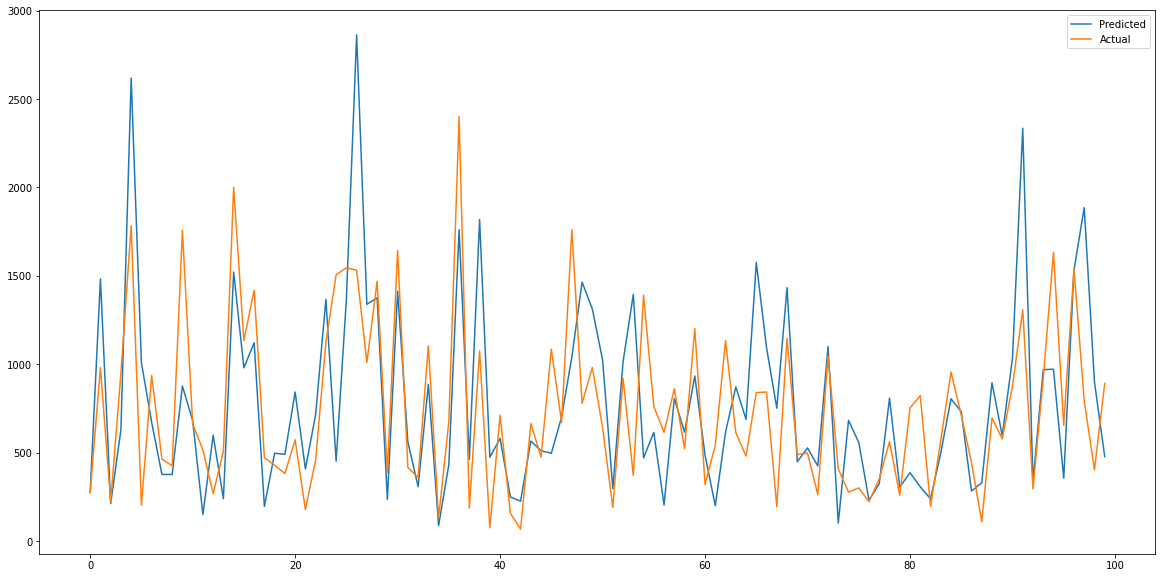

In [94]:
# creating DecisionTree model
DecisionTree = DecisionTreeRegressor()

# training and evaluating the DecisionTree
train_and_score(DecisionTree,X_train, X_test, y_train, y_test)

==========================Features Importance============================

 DecisionTreeRegressor()  



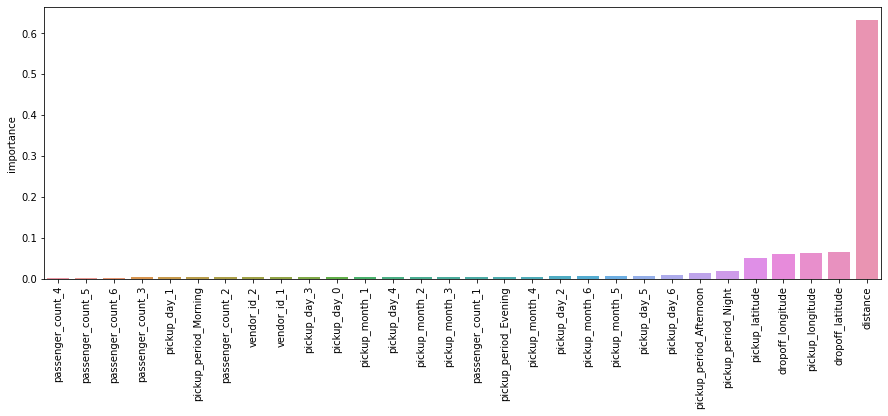

In [95]:
get_features_importance(DecisionTree)

---
# Random forest
---

In [96]:
# importing the RandomForest Regressor model
from sklearn.ensemble import RandomForestRegressor

In [97]:
# creating Random Forest Regressor model
rfr=RandomForestRegressor(max_depth = 13, n_estimators=100)

MSE : 88571.12551141038
RMSE : 297.6090144995786
MAPE : 0.35469876181384735
R2 : 0.6706960073283844
Adjusted R2 :  0.6705642312638758 



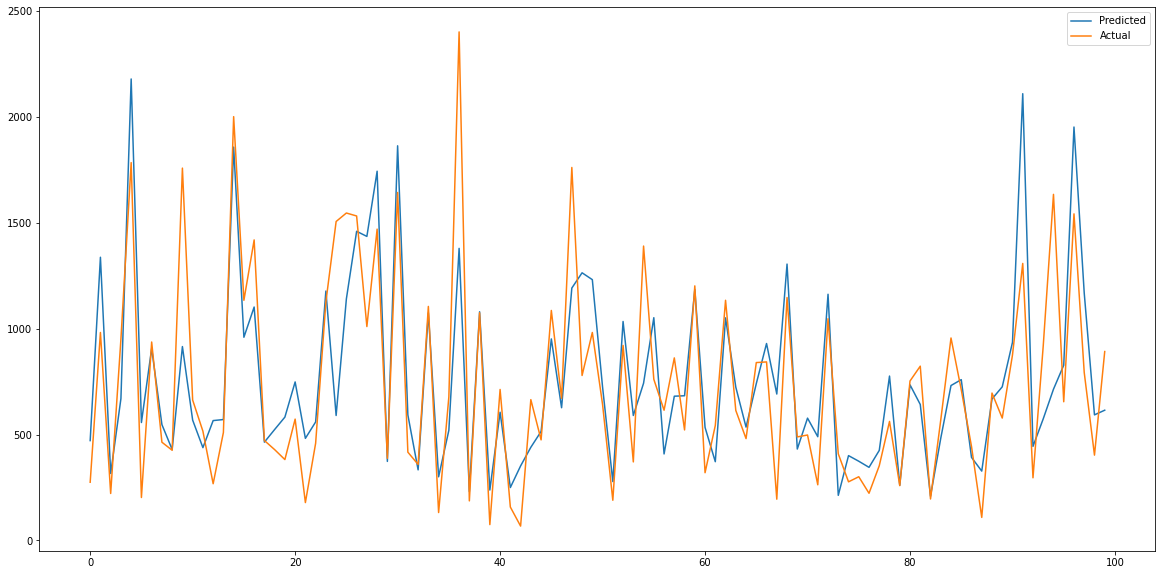

In [98]:
# training and evaluating the Random Forest Regressor
train_and_score(rfr,X_train, X_test, y_train, y_test,best_parameter=True)

## implimenting grid search random forest
---

In [99]:
# creating RandomForestRegressor model
rfr=RandomForestRegressor()

In [100]:
# finding the best parameters for knn_model by gridsearchcv
grid_values_rf = {'n_estimators': [25,50,100],'max_depth': [7,10,13]}
rfr_grid = GridSearchCV(estimator=rfr,param_grid = grid_values_rf, scoring='neg_mean_squared_error',cv=3,verbose=5,n_jobs=-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters found out to be : {'max_depth': 13, 'n_estimators': 100}
 
where negative mean squared error is:  -91658.01811450301 

MSE : 88590.49888101088
RMSE : 297.64156107810425
MAPE : 0.3549434812549558
R2 : 0.6706239778952694
Adjusted R2 :  0.6704921730070736 



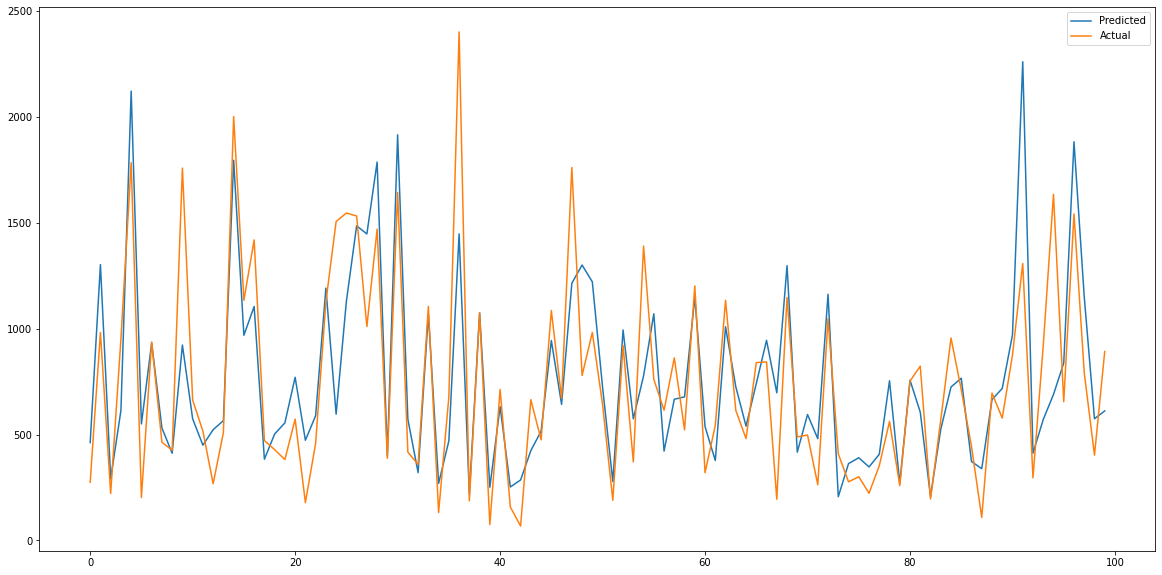

In [101]:
# training and evaluating the Random Forest Regressor
train_and_score(rfr_grid,X_train, X_test, y_train, y_test)

==========================Features Importance============================

 RandomForestRegressor(max_depth=13)  



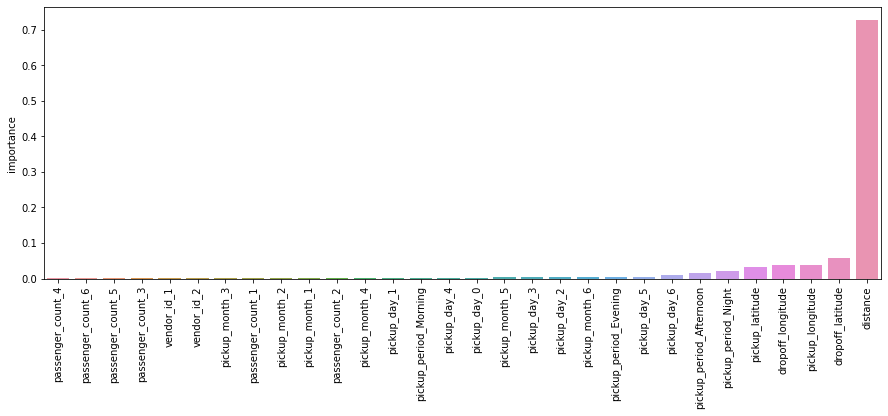

In [102]:
get_features_importance(rfr_grid.best_estimator_)

---
#XGboost
---

In [103]:
# importing the xgb Regressor model
from xgboost import XGBRegressor

In [104]:
# creating XGBRegressor model
xgbr=XGBRegressor()

[15:46:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE : 90279.49158896603
RMSE : 300.46545822933797
MAPE : 0.35952415376277785
R2 : 0.6643443688340611
Adjusted R2 :  0.6642100510635829 



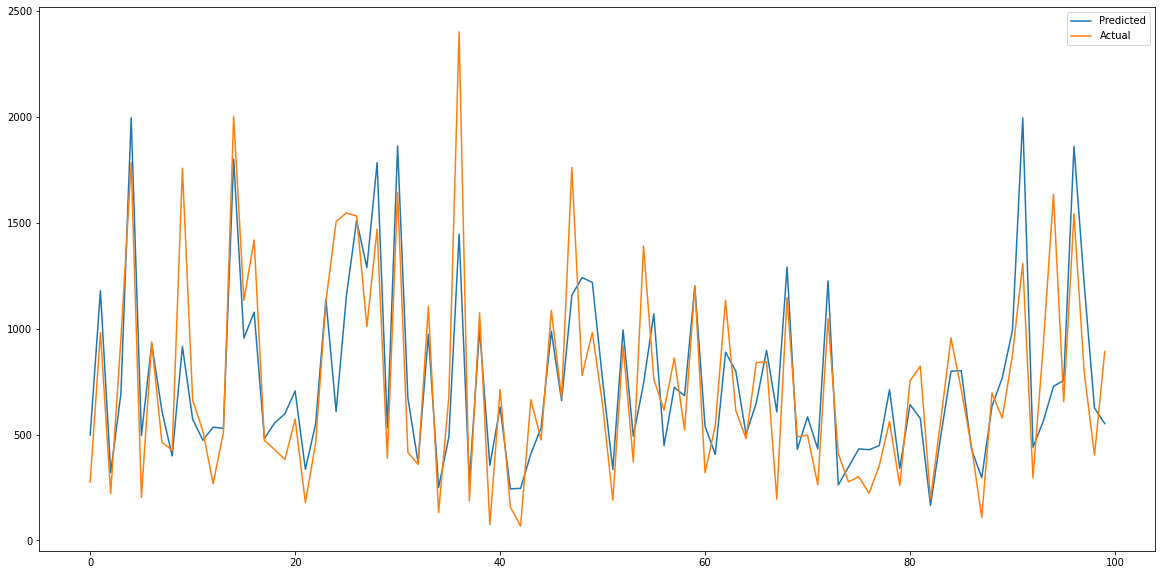

In [105]:
# training and evaluating the xgb_grid
train_and_score(xgbr,X_train, X_test, y_train, y_test)

## implimenting grid search xgb
---

In [106]:
# creating XGBRegressor model
xgbr=XGBRegressor()

In [107]:
# finding the best parameters for XGBRegressor by gridsearchcv
xgbr_param={'n_estimators': [25,50,100],'max_depth': [7,10,13]}
xgbr_grid=GridSearchCV(estimator=xgbr,param_grid=xgbr_param,cv=3,scoring='neg_mean_squared_error',verbose=5,n_jobs=-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[15:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best parameters found out to be : {'max_depth': 7, 'n_estimators': 100}
 
where negative mean squared error is:  -84266.0205294427 

MSE : 81835.1105632921
RMSE : 286.06836693925476
MAPE : 0.3346314329787892
R2 : 0.6957402483753752
Adjusted R2 :  0.6956184941496453 



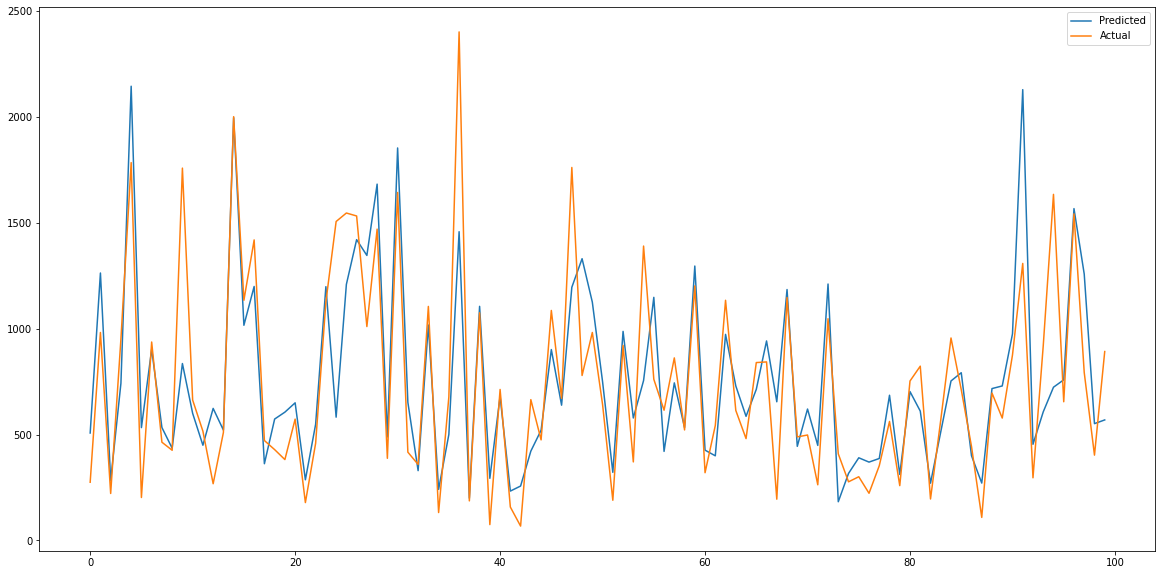

In [108]:
# training and evaluating the xgb_grid
train_and_score(xgbr_grid,X_train, X_test, y_train, y_test)

==========================Features Importance============================

 XGBRegressor(max_depth=7)  



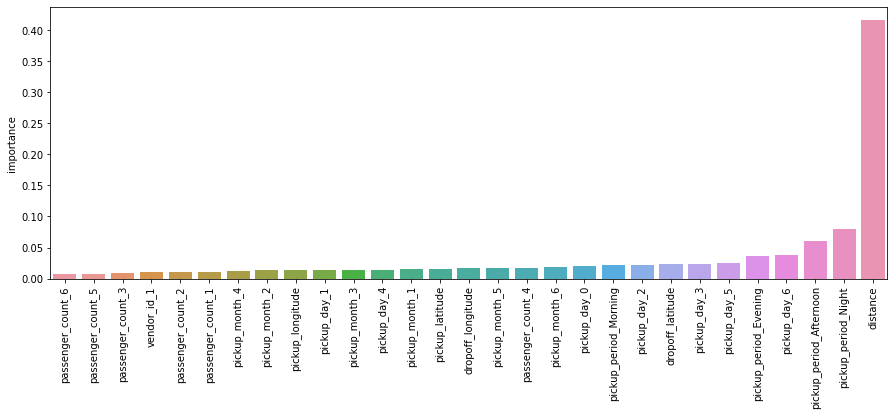

In [109]:
get_features_importance(xgbr_grid.best_estimator_)

---
#lightGBM
---

In [110]:
# importing the lightgbm Regressor model
import lightgbm as lgb

In [111]:
# creating XGBRegressor model
lgbr=lgb.LGBMRegressor()

 
where negative mean squared error is:  defaultdict(<class 'dict'>, {}) 

MSE : 80585.45055144836
RMSE : 283.8757660517156
MAPE : 0.3335735639157812
R2 : 0.7003864355950373
Adjusted R2 :  0.7002665406126827 



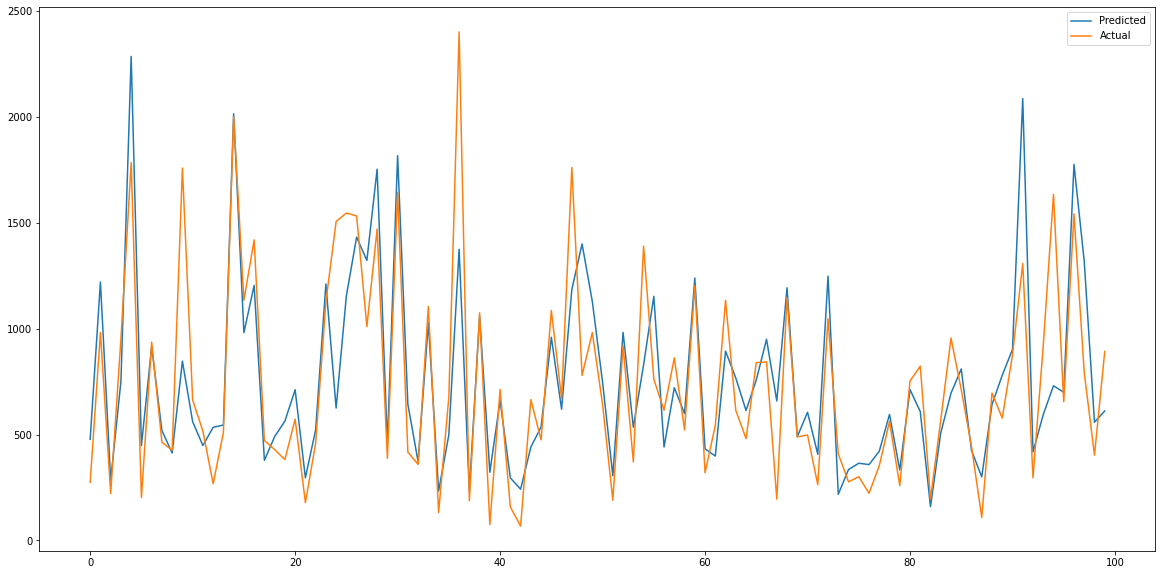

In [112]:
#calling run_model to train,fit and evalution of catboost model
train_and_score(lgbr,X_train, X_test, y_train, y_test)

In [113]:
# creating XGBRegressor model
lgbr=lgb.LGBMRegressor()

In [114]:
# finding the best parameters for XGBRegressor by gridsearchcv
lgbr_para={'n_estimators': [100,125,150],'max_depth': [13,15,17]}
lgbr_grid=GridSearchCV(estimator=lgbr,param_grid=lgbr_para,cv=3,scoring='neg_mean_squared_error',verbose=5,n_jobs=-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
The best parameters found out to be : {'max_depth': 15, 'n_estimators': 150}
 
where negative mean squared error is:  -81158.38682793926 

MSE : 79618.43477866297
RMSE : 282.1673878722751
MAPE : 0.3293953757344296
R2 : 0.703981762549685
Adjusted R2 :  0.7038633062927854 



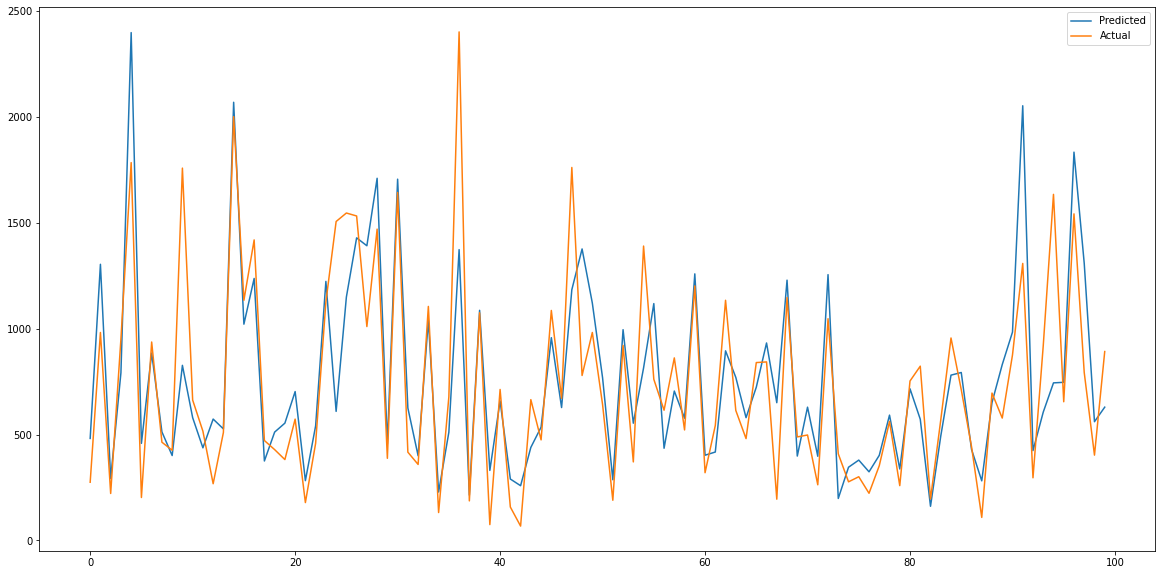

In [115]:
#calling run_model to train,fit and evalution of catboost model
train_and_score(lgbr_grid,X_train, X_test, y_train, y_test)

==========================Features Importance============================

 LGBMRegressor(max_depth=15, n_estimators=150)  



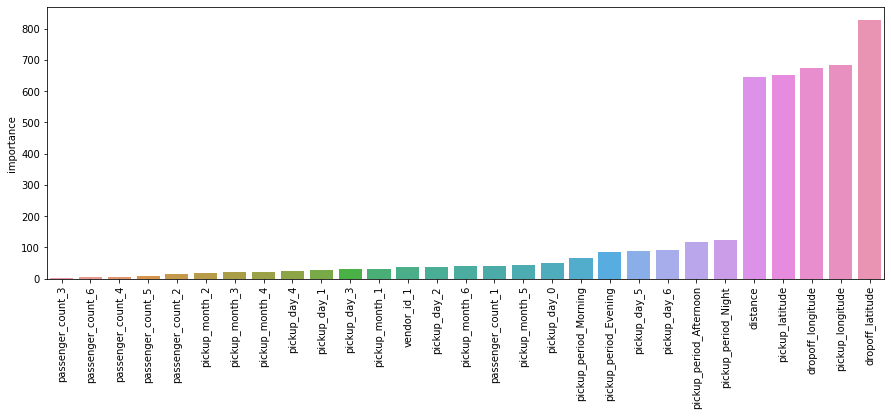

In [116]:
get_features_importance(lgbr_grid.best_estimator_)

---
# score matrix for all the models 
---

In [117]:
#creating dictionary to store all the metrices 
dict={'Mean_square_error':mean_sq_error,'Root_Mean_square_error':root_mean_sq_error,'mean_abs_per_error':mean_abs_per_error,'R2':r2_list,'Adjusted_R2':adj_r2_list}

In [118]:
# list of all models
model_name=['Linear','Lasso','Ridge','Desision_tree','Random_Forest','Random_Forest_grid','Xtreme_GB','Xtreme_GB_grid','LightGBM','LightGBM_grid']

In [119]:
# converting dictionary to dataframe
matrix_df=pd.DataFrame.from_dict(dict,orient="index",columns=model_name)

In [120]:
# taking the transpose of the dataframe to make it more visual appealing
final_matrices=matrix_df.transpose().reset_index().rename(columns={'index':'Models'})
final_matrices

,Models,Mean_square_error,Root_Mean_square_error,mean_abs_per_error,R2,Adjusted_R2
0,Linear,110578.470205,332.533412,0.428879,0.591837,0.591346
1,Lasso,110578.186691,332.532986,0.428948,0.591838,0.591347
2,Ridge,110578.812451,332.533927,0.429030,0.591835,0.591345
3,Desision_tree,177931.018373,421.818703,0.474852,0.338459,0.338195
4,Random_Forest,88571.125511,297.609014,0.354699,0.670696,0.670564
5,Random_Forest_grid,88590.498881,297.641561,0.354943,0.670624,0.670492
6,Xtreme_GB,90279.491589,300.465458,0.359524,0.664344,0.664210
7,Xtreme_GB_grid,81835.110563,286.068367,0.334631,0.695740,0.695618
8,LightGBM,80585.450551,283.875766,0.333574,0.700386,0.700267
9,LightGBM_grid,79618.434779,282.167388,0.329395,0.703982,0.703863


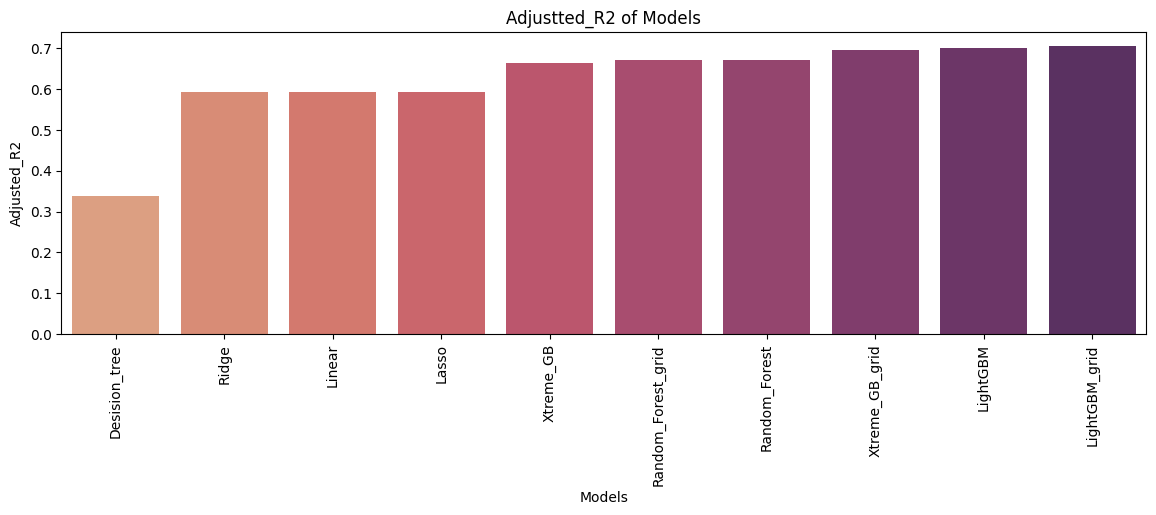

In [121]:
#creating bar plot to visualize the Adjusted R2 of model 
plt.figure(figsize=(14,4),dpi=100)
sns.barplot(x='Models',y='Adjusted_R2',data=final_matrices.sort_values('Adjusted_R2'),palette="flare").set(title='Adjustted_R2 of Models')
plt.xticks(rotation=90);

---
#Lime
---



---


# Conclusion

---



we are getting aur bes t model as lightgbm with the best r2 score of 0.70 with MAPE of 0.33 